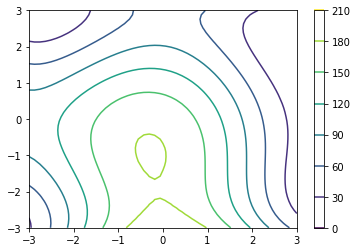

In [12]:
import os

import gpytorch
from botorch.models.gpytorch import BatchedMultiOutputGPyTorchModel
from botorch.models.utils import multioutput_to_batch_mode_transform

import matplotlib.pyplot as plt
import torch
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.objective import IdentityMCObjective
from botorch.fit import fit_gpytorch_model
from botorch.models import ModelListGP, SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.optim import optimize_acqf
from botorch.utils.sampling import sample_hypersphere
from botorch.utils.transforms import t_batch_mode_transform
from gpytorch.constraints import Interval
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
SMOKE_TEST = os.environ.get("SMOKE_TEST")
# def f(x1, x2): return np.sin(x1+x2)+(x1-x2)**2-1.5*x1+2.5*x2+1
def f(x1, x2): return (x1**2+x2-11)**2+(x1+x2**2-7)**2
x1 = np.linspace(-3, 3)
x2 = np.linspace(-3, 3)
X1, X2 = np.meshgrid(x1, x2)
# F = f(x1, x2) + random.random()
plt.contour(X1, X2, f(X1, X2)+random.random(), cmap = 'viridis')
cbar = plt.colorbar()


In [13]:
torch.cuda.is_available()

True

In [14]:
tkwargs = {
    # "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "device": torch.device("cpu"),
    "dtype": torch.double,
    # "dtype": torch.float,
}

In [15]:
def smooth_mask(x, a, eps=2e-3):
    """Returns 0ish for x < a and 1ish for x > a"""
    return torch.nn.Sigmoid()((x - a) / eps)


def smooth_box_mask(x, a, b, eps=2e-3):
    """Returns 1ish for a < x < b and 0ish otherwise"""
    return smooth_mask(x, a, eps) - smooth_mask(x, b, eps)

class ExpectedCoverageImprovement(MCAcquisitionFunction):
    def __init__(
        self,
        model,
        constraints,
        punchout_radius,
        bounds,
        num_samples=512,
        **kwargs,
    ):
        """Expected Coverage Improvement (q=1 required, analytic)

        Right now, we assume that all the models in the ModelListGP have
        the same training inputs.

        Args:
            model: A ModelListGP object containing models matching the corresponding constraints.
                All models are assumed to have the same training data.
            constraints: List containing 2-tuples with (direction, value), e.g.,
                [('gt', 3), ('lt', 4)]. It is necessary that
                len(constraints) == model.num_outputs.
            punchout_radius: Positive value defining the desired minimum distance between points
            bounds: torch.tensor whose first row is the lower bounds and second row is the upper bounds
            num_samples: Number of samples for MC integration
        """
        super().__init__(model=model, objective=IdentityMCObjective(), **kwargs)
        assert len(constraints) == model.num_outputs
        assert all(direction in ("gt", "lt") for direction, _ in constraints)
        assert punchout_radius > 0
        self.constraints = constraints
        self.punchout_radius = punchout_radius
        self.bounds = bounds
        self.base_points = self.train_inputs
        self.ball_of_points = self._generate_ball_of_points(
            num_samples=num_samples,
            radius=punchout_radius,
            device=bounds.device,
            dtype=bounds.dtype,
        )
        self._thresholds = torch.tensor(
            [threshold for _, threshold in self.constraints]
        ).to(bounds)
        assert (
            all(ub > lb for lb, ub in self.bounds.T) and len(self.bounds.T) == self.dim
        )

    @property
    def num_outputs(self):
        return self.model.num_outputs

    @property
    def dim(self):
        return self.train_inputs.shape[-1]

    @property
    def train_inputs(self):
        return self.model.models[0].train_inputs[0]

    def _generate_ball_of_points(
        self, num_samples, radius, device=None, dtype=torch.double
    ):
        """Creates a ball of points to be used for MC."""
        tkwargs = {"device": device, "dtype": dtype}
        z = sample_hypersphere(d=self.dim, n=num_samples, qmc=True, **tkwargs) # Not using self.dim
        r = torch.rand(num_samples, 1, **tkwargs) ** (1 / self.dim)
        
        return radius * r * z

    def _get_base_point_mask(self, X):
        distance_matrix = self.model.models[0].covar_module.base_kernel.covar_dist(
            X, self.base_points.double()
        )   # Note to self: self.base_points is fp32
            # Should standardize all to fp64?
        return smooth_mask(distance_matrix, self.punchout_radius)

    def _estimate_probabilities_of_satisfaction_at_points(self, points):
        print("Entered estimate prob")
        probabilities = torch.zeros((points.shape[0:2]))
        for i in range(len(points)):
            with gpytorch.settings.fast_pred_var(), torch.no_grad():
                # print("Before test dist")
                # print(f"self.model::::::: {self.model.posterior()[0]}")
                # test_dist = self.model.posterior(points)
                
                #test_dist = model(points[i].float()) # Calculate posterior
                test_dist = self.model.models[0](points[i].float())
                # print("Before pred_means")
                pred_means = test_dist.loc
            pred_samples = test_dist.sample(torch.Size((50,))).exp()
            prob_of_one_point = (pred_samples / pred_samples.sum(-2, keepdim=True))[:,1,:].mean(0)
            probabilities[i] = prob_of_one_point
        return probabilities

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X):
        """Evaluate Expected Improvement on the candidate set X."""
        ball_around_X = self.ball_of_points + X
        domain_mask = smooth_mask(
            ball_around_X, self.bounds[0, :], self.bounds[1, :]
        ).prod(dim=-1)
        # print(f"domain mask: {domain_mask.shape}")
        num_points_in_integral = domain_mask.sum(dim=-1)
        # print(f"num_points_in_integral: {num_points_in_integral.shape}")
        # print("Right before base_point_mask")
        # print(f"ball dtype: {ball_around_X.dtype}")
        # print(f"ball shape: {ball_around_X.shape}")
        base_point_mask = self._get_base_point_mask(ball_around_X).prod(dim=-1)
        # print(f"base_point_mask: {base_point_mask.shape}")
        prob = self._estimate_probabilities_of_satisfaction_at_points(ball_around_X)
        # print(f"prob: {prob.shape}")
        masked_prob = prob * domain_mask * base_point_mask
        y = masked_prob.sum(dim=-1) / num_points_in_integral
        return y

In [16]:
# from gpytorch.models import ExactGP
# from botorch.models.gpytorch import GPyTorchModel
# from gpytorch.likelihoods import DirichletClassificationLikelihood
# from gpytorch.means import ConstantMean
# from gpytorch.kernels import ScaleKernel, RBFKernel

# # We will use the simplest form of GP model, exact inference
# class DirichletGPModel(ExactGP, GPyTorchModel):
#     def __init__(self, train_x, train_y, likelihood, num_classes, input_transform=True):
#         super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = ConstantMean()
#         self.covar_module = ScaleKernel(RBFKernel())

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [17]:
def get_and_fit_gp(X, Y):
    # Find optimal model hyperparameters
    X = X.float()
    likelihood = DirichletClassificationLikelihood(Y[:,0].long(), learn_additional_noise=True)
    model = DirichletGPModel(X, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    '''
    Temporary hack (X.float())
    need to fix dtype later
    '''

    for i in range(50):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        # model.eval()
        # likelihood.eval()
        output = model(X)
        # Calc loss and backprop gradients
        # model.train()
        # likelihood.train()
        loss = -mll(output, likelihood.transformed_targets).sum()
        loss.backward()
        # if (i+1) % 5 == 0:
        #     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #         i + 1, 50, loss.item(),
        #         model.covar_module.base_kernel.lengthscale.mean().item(),
        #         model.likelihood.second_noise_covar.noise.mean().item()
        #     ))
        optimizer.step()
    return model

In [18]:
def yf(x):
    v = (x[:,0]**2+x[:,1]-11)**2+(x[:,0]+x[:,1]**2-7)**2
    for i in range(len(v)):
        if v[i] > 160:
            v[i] = 1
        else:
            v[i] = 0
    return torch.stack((v, v), dim=-1)

In [19]:
bounds = torch.tensor([[-3, -3], [3, 3]], **tkwargs)
lb, ub = bounds
dim = len(lb)
punchout_radius = 0.6

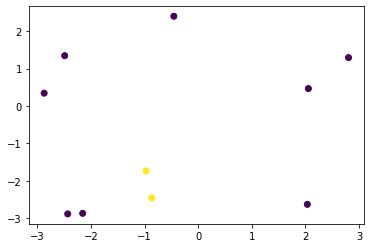

In [20]:
# num_init_points = 5
# num_total_points = 20 
# X = lb + (ub - lb) * SobolEngine(dim, scramble=True).draw(num_init_points).to(**tkwargs)
# Y = yf(X)
# plt.scatter(X.cpu().numpy()[:, 0], X.cpu().numpy()[:, 1], c=Y.cpu()[:,0])


num_init_points = 10
num_total_points = 15 
# X = lb + (ub - lb) * SobolEngine(dim, scramble=True).draw(num_init_points).to(**tkwargs)
def get_first_N_points(num):
    with open("./trainx.txt","r") as x:
        data = eval(x.read())
    train_x = torch.tensor(data)[0:num,:]
    with open("./trainy.txt","r") as y:
        data = eval(y.read())
    train_y = torch.tensor(data)[0:num]
    return train_x, train_y


X, Y = get_first_N_points(10)

X = X.double()
Y = Y.unsqueeze(-1).repeat(1,2).double()
# print(Y)
# print(Y.shape)
# Y = yf(X)
plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=Y[:,0])


In [21]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from botorch.models.gpytorch import BatchedMultiOutputGPyTorchModel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
X = X.float()
likelihood = DirichletClassificationLikelihood(Y[:,0].long(), learn_additional_noise=True)
model = DirichletGPModel(X, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

In [22]:
constraints = [("lt", 1.01), ("gt", 0.95)]
# normalization
# mean = X.mean(dim=-2, keepdim=True)
# std = X.std(dim=-2, keepdim=True) + 1e-6 # prevent dividing by 0
# X = (X - mean) / std
# testnum = 1
'''
We need to do something about the likelihood eval
'''
while len(X) < num_total_points:
    # We don't have to normalize X since the domain is [0, 1]^2. Make sure to
    # appropriately adjust the punchout radius if the domain is normalized.
    print("Checkpoint: Calling get_and_fit_gp")
    # gp_models = [get_and_fit_gp(X, Y[:, 0 : 1])]
    gp_models = get_and_fit_gp(X.float(), Y[:, 0: 1])
    print("Checkpoint: Calling ModelListGP")
    model_list_gp = ModelListGP(gp_models, gp_models) # Temporary hack
    print("Checkpoint: ECI")
    eci = ExpectedCoverageImprovement(
        model=model_list_gp,
        constraints=constraints,
        punchout_radius=punchout_radius,
        bounds=bounds,
        num_samples=512,
    )
    print("Checkpoint: x_next")
    # Switch to eval mode
    model_list_gp.models[0].eval()

    #likelihood.eval()
    x_next, _ = optimize_acqf(
        acq_function=eci,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=512,
    )
    print(f"Got x_next: {x_next}")
    # x_next = torch.tensor([[testnum,testnum+0.1]])
    # testnum += 1
    print("Checkpoint: y_next")
    y_next = yf(x_next)
    # print(f"x_next dtype:{x_next.dtype}")
    # print(f"x_next shape:{x_next.shape}")
    print("Checkpoint: finished y_next")
    # print(f"X shape:{X.shape}")
    # print(f"Y shape:{Y.shape}")
    # print(X)
    X = torch.cat((X, x_next))
    Y = torch.cat((Y, y_next))
    print("After cat")
    # print(X)
    # print(f"X shape:{X.shape}")
    # print(f"Y shape:{Y.shape}")

Checkpoint: Calling get_and_fit_gp
Checkpoint: Calling ModelListGP
Checkpoint: ECI
Checkpoint: x_next
Entered estimate prob


d:\Python310\lib\site-packages\gpytorch\lazy\triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Entered estimate prob
Entered estimate prob
Entered estimate prob


d:\Python310\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
d:\Python310\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
d:\Python310\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Got x_next: tensor([[ 0.1543, -1.6428]], dtype=torch.float64)
Checkpoint: y_next
Checkpoint: finished y_next
After cat
Checkpoint: Calling get_and_fit_gp
Checkpoint: Calling ModelListGP
Checkpoint: ECI
Checkpoint: x_next
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob


d:\Python310\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
d:\Python310\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
d:\Python310\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Got x_next: tensor([[ 0.2193, -2.8146]], dtype=torch.float64)
Checkpoint: y_next
Checkpoint: finished y_next
After cat
Checkpoint: Calling get_and_fit_gp
Checkpoint: Calling ModelListGP
Checkpoint: ECI
Checkpoint: x_next
Entered estimate prob
Entered estimate prob
Entered estimate prob


d:\Python310\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
d:\Python310\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
d:\Python310\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Got x_next: tensor([[-0.5299, -0.6203]], dtype=torch.float64)
Checkpoint: y_next
Checkpoint: finished y_next
After cat
Checkpoint: Calling get_and_fit_gp
Checkpoint: Calling ModelListGP
Checkpoint: ECI
Checkpoint: x_next
Entered estimate prob
Entered estimate prob
Entered estimate prob


d:\Python310\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
d:\Python310\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
d:\Python310\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Got x_next: tensor([[ 0.6942, -0.6468]], dtype=torch.float64)
Checkpoint: y_next
Checkpoint: finished y_next
After cat
Checkpoint: Calling get_and_fit_gp
Checkpoint: Calling ModelListGP
Checkpoint: ECI
Checkpoint: x_next
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob


d:\Python310\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
d:\Python310\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
d:\Python310\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Entered estimate prob
Got x_next: tensor([[-1.5292, -0.6515]], dtype=torch.float64)
Checkpoint: y_next
Checkpoint: finished y_next
After cat


d:\Python310\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\Leo\AppData\Local\Temp\ipykernel_6820\3191119530.py:32: UserWarning: No contour levels were found within the data range.
  ax.contour(Xplt.cpu(), Yplt.cpu(), Zplt.cpu(), [-10, 0], colors="k")


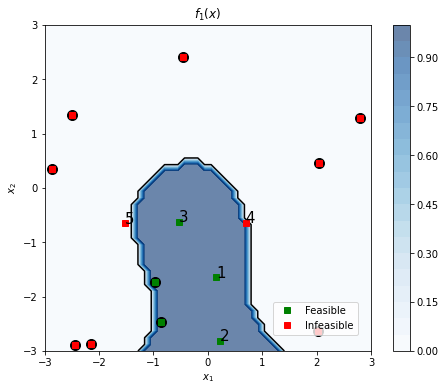

In [23]:
N1, N2 = 50, 50
Xplt, Yplt = torch.meshgrid(
    torch.linspace(-3, 3, N1, **tkwargs), torch.linspace(-3, 3, N2, **tkwargs)
)
xplt = torch.stack(
    (
        torch.reshape(Xplt, (Xplt.shape[0] * Xplt.shape[1],)),
        torch.reshape(Yplt, (Yplt.shape[0] * Yplt.shape[1],)),
    ),
    dim=1,
)
yplt = yf(xplt)
Zplt = torch.reshape(yplt[:, 0], (N1, N2)) 
def identify_samples_which_satisfy_constraints(X, constraints):
    """
    Takes in values (a1, ..., ak, o) and returns (a1, ..., ak, o)
    True/False values, where o is the number of outputs.
    """
    successful = torch.ones(X.shape).to(X)
    for model_index in range(X.shape[-1]):
        these_X = X[..., model_index]
        direction, value = constraints[model_index]
        successful[..., model_index] = (
            these_X < value if direction == "lt" else these_X > value
        )
    return successful


fig, ax = plt.subplots(figsize=(8, 6))
h1 = ax.contourf(Xplt.cpu(), Yplt.cpu(), Zplt.cpu(), 20, cmap="Blues", alpha=0.6)
fig.colorbar(h1)
ax.contour(Xplt.cpu(), Yplt.cpu(), Zplt.cpu(), [-10, 0], colors="k")

feasible_inds = (
    identify_samples_which_satisfy_constraints(Y, constraints)
    .prod(dim=-1)
    .to(torch.bool)
)
ax.plot(X[feasible_inds, 0].cpu(), X[feasible_inds, 1].cpu(), "sg", label="Feasible")
ax.plot(
    X[~feasible_inds, 0].cpu(), X[~feasible_inds, 1].cpu(), "sr", label="Infeasible"
)
# ax.scatter(X[:5, 0], X[:5, 1], marker = 'o', s=100, color = 'k')
ax.scatter(X.cpu()[:10, 0], X.cpu()[:10, 1], marker = 'o', s=100, color = 'k')
ind = 1
for i in X[10:]:
    plt.text(i[0],i[1],ind, size = 15)
    ind += 1
ax.legend(loc=[0.7, 0.05])
ax.set_title("$f_1(x)$")  # Recall that f1(x) = f2(x)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_aspect("equal", "box")
# ax.set_xlim([-0.05, 1.05])
# ax.set_ylim([-0.05, 1.05])
plt.show()